here, I try to implement a gradient function for a simple spiking neuron

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 

example implementation of gradient for a layer 

In [5]:
# example implementation 
input = tf.Variable([3.0], dtype=tf.float32)

@tf.custom_gradient
def clip_grad_layer(x):
  def grad(dy):
    return tf.clip_by_value(dy, -0.1, 0.1)
  return tf.identity(x), grad

output_clip = clip_grad_layer(input)
grad_clip = tf.gradients(output_clip, input)

# output without gradient clipping in the backwards pass for comparison:
output = tf.identity(input)
grad = tf.gradients(output, input)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  print("with clipping:", sess.run(grad_clip)[0])
  print("without clipping:", sess.run(grad)[0])

with clipping: [0.1]
without clipping: [1.]


next I implement only neuron input to output using the pseudo derivative, note that it is assumed here that the voltage is normalized.
$$\frac{dz_j(t)}{dv_j(t)} := max \{0,1-|v_j(t)|\} $$ 
$$v_j(t)=\frac{V_j(t)-B_j(t)}{B_j(t)}$$ 


In [50]:
membrane_voltage = tf.Variable(0.0,dtype=tf.float32)
@tf.custom_gradient
def spike_generator(x):
    def grad(dy):
        
        return tf.maximum(tf.constant(0.0,dtype=tf.float32),tf.subtract(tf.constant(1.0,dtype=tf.float32),
                                       tf.abs(x)))
    return tf.where(tf.greater_equal(x,0),tf.constant(1.0,dtype=tf.float32),
                                          tf.constant(0.0,dtype=tf.float32)), grad

spike=spike_generator(membrane_voltage)
gradient_spike = tf.gradients(spike,membrane_voltage)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("spike: ", sess.run(spike))
    print("gradient: ", sess.run(gradient_spike))


spike:  1.0
gradient:  [1.0]


Text(0.5, 0, 'voltage')

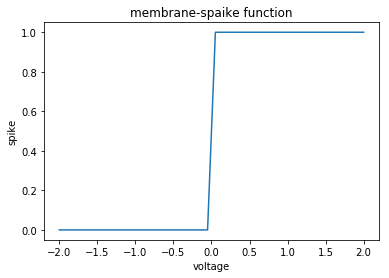

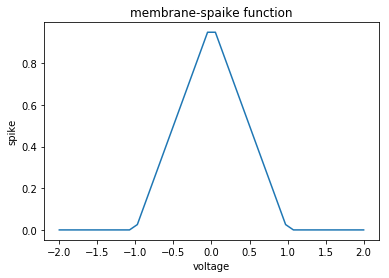

In [51]:
membrane_voltage = tf.Variable(tf.linspace(-2.0,2.0,num=40))

@tf.custom_gradient
def spike_generator(x):
    def grad(dy):
        return tf.maximum(tf.scalar_mul(0.0,x),tf.subtract(tf.constant(1.0,dtype=tf.float32),
                                       tf.abs(x)))
    return tf.where(tf.greater_equal(x,0),tf.constant(1.0,shape=[40,1],dtype=tf.float32),
                                          tf.constant(0.0,shape=[40,1],dtype=tf.float32)), grad

spike=spike_generator(membrane_voltage)
gradient_spike = tf.gradients(spike,membrane_voltage)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    voltage=sess.run(membrane_voltage)
    I=sess.run(spike)
    J=sess.run(gradient_spike)
plt.figure()
plt.plot(voltage, I)
plt.title('membrane-spaike function')
plt.ylabel('spike')
plt.xlabel('voltage')
# 
plt.figure()
plt.plot(voltage, np.asarray(J).flatten())
plt.title('membrane-spaike function')
plt.ylabel('spike')
plt.xlabel('voltage')

In [74]:
class LIFNeuron(object):
    def __init__(self,n=1,tau_m=5.0,v_Theta=1,v_reset=0, tau_s=5.0, tau_refract=2.0):
        self.n=n
        self.tau_m=tau_m
        self.v_Theta=v_Theta
        self.v_reset=v_reset
        self.tau_s=tau_s
        self.tau_refract=tau_refract
        self.graph=tf.Graph()
        with self.graph.as_default():
            self.get_vars_and_ph()
            self.potential, self.has_fired, self.conductance=self.calculate_spike_op()
            
    def get_vars_and_ph(self):
        self.V=tf.Variable(tf.constant(0.0,shape=[self.n,1],dtype=tf.float32),name='V')
        self.has_fired=tf.Variable(tf.constant(self.v_reset,shape=[self.n,1],dtype=tf.float32),name='has_fired')
        self.V_Theta=tf.constant(self.v_Theta,shape=[self.n,1],dtype=tf.float32,name='V_Theta')
        self.V_Reset=tf.constant(self.v_reset,shape=[self.n,1],dtype=tf.float32,name='V_Reset')
        self.I_ext=tf.placeholder(dtype=tf.float32,shape=[self.n,1],name='I_ext')
        self.dt=tf.placeholder(dtype=tf.float32, name='dt')
        self.W=tf.Variable(tf.random.normal(shape=[self.n,self.n],mean=0.0,stddev=0.1,dtype=tf.float32),name='W')
        self.G=tf.Variable(tf.ones(shape=[self.n,1],dtype=tf.float32),name='G')
        self.S=tf.Variable(tf.zeros(shape=[self.n,self.n],dtype=tf.float32),name='S')
        self.I_syn=tf.Variable(tf.ones(shape=[self.n,1],dtype=tf.float32),name='I_syn')
        self.Tau_refractory=tf.constant(self.tau_refract,shape=[self.n,1],dtype=tf.float32,name='T_refractory')
        self.T_Reset=tf.Variable(tf.constant(0.0,shape=[self.n,1],dtype=tf.float32),name='T_refractory')
    def calculate_spike_op(self):
        # determine spikes 
        has_fired=tf.greater_equal(self.V,self.V_Theta)
        v_update=tf.where(has_fired,self.V_Reset,self.V)
        # update conductance 
        I_ext=tf.add(self.I_ext,0.0)
        dS_op=tf.divide(tf.negative(self.S),self.tau_s)
        has_fired_float=tf.dtypes.cast(has_fired,tf.float32)
        has_fired_ax=tf.tile(has_fired_float,[1,self.n])
        S_op=tf.assign_add(self.S,tf.add(has_fired_ax,dS_op*self.dt))
        G_op=tf.assign(self.G,tf.reduce_sum(tf.multiply(self.W,S_op), 1, keepdims=True))
        I_syn=tf.assign(self.I_syn,tf.add(tf.multiply(G_op,v_update),I_ext))
        ## update voltages
        # find neurons in refractory 
        t_subtract= tf.assign(self.T_Reset,tf.subtract(self.T_Reset,tf.constant(1.0,shape=[self.n,1])))
        t_margin=tf.assign(self.T_Reset,tf.where(tf.less(t_subtract,0.0),
                                        tf.constant(0.0,shape=[self.n,1]),
                                       t_subtract))
        t_reset_update=tf.assign(self.T_Reset,tf.where(has_fired,self.Tau_refractory,t_margin))
        eligilible_update=tf.equal(t_reset_update,tf.constant(0.0,shape=[self.n,1]))
        # integrate voltage
        dV_op=tf.where(eligilible_update,tf.divide(
           tf.subtract(I_syn,v_update),self.tau_m),self.V_Reset)
        V_op=tf.assign(self.V,tf.minimum(self.V_Theta,tf.add(v_update,tf.multiply(dV_op,self.dt))))
        return V_op, has_fired , G_op
    
        

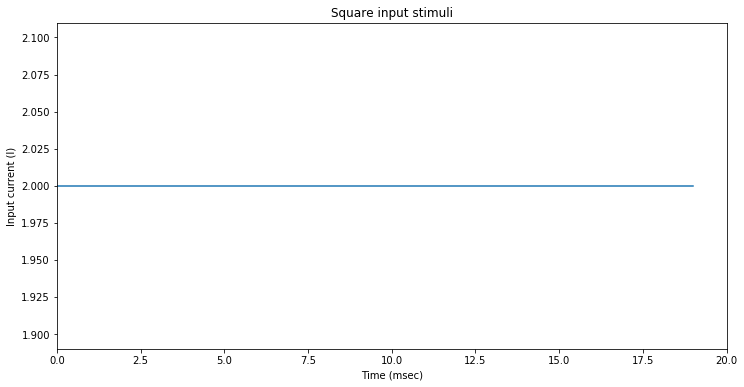

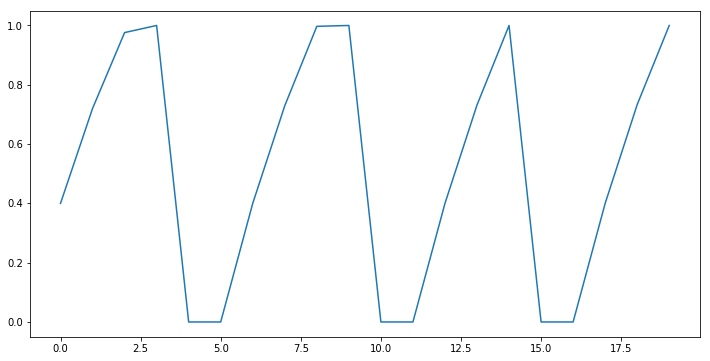

In [76]:
T = 20
# Duration of each time step in ms
dt = 1
# Number of iterations = T/dt
steps = int(T / dt)
# Output variables
I = []
U = []
V= []
G=[]
n_Neur=1
neuron = LIFNeuron(n=n_Neur)

with tf.Session(graph=neuron.graph) as sess:

    sess.run(tf.global_variables_initializer())    

    for step in range(steps):
        
        t = step * dt
        # Set input current in mA
        I_ext = np.full([n_Neur,1],2.0)
        
        feed = { neuron.I_ext: I_ext, neuron.dt: dt}
        
        #u, v = sess.run([neuron.potential, neuron.V_Update], feed_dict=feed)
        u,v,g = sess.run([neuron.potential,neuron.has_fired, neuron.conductance], feed_dict=feed)

        I.append(I_ext.flatten())
        U.append(u.flatten())
        V.append(v.flatten())
        G.append(g.flatten())

U1=np.array(U)
U2=np.array(V)

I_ext=np.expand_dims(I_ext,axis=0)
plt.rcParams["figure.figsize"] =(12,6)
# Draw the input current ahas_fired_op_floatnd the membrane potential
plt.figure()
plt.plot([i for i in I])
plt.title('Square input stimuli')
plt.ylabel('Input current (I)')
plt.xlabel('Time (msec)')
plt.xlim([0,T])
plt.figure()
plt.plot([u for u in U1])
a=plt.get_cmap()